# Predikcija odliva klijenata banaka - Stablo olučivanja

In [3]:
# Uključivanje potrebnih biblioteka
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import ks_2samp

In [4]:
# Učitavanje detaseta
df = pd.read_csv('bank.csv',na_values=['','-',' '])

display(df.head())
df.info()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction.Score,Card.Type,Point.Earned
0,Hargrave,619,France,Female,NaN,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,Hill,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,Onio,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,Boni,699,France,Female,39.0,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,NaN,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Surname             4897 non-null   object 
 1   CreditScore         4898 non-null   int64  
 2   Geography           4896 non-null   object 
 3   Gender              4898 non-null   object 
 4   Age                 4895 non-null   float64
 5   Tenure              4898 non-null   int64  
 6   Balance             4898 non-null   float64
 7   NumOfProducts       4898 non-null   int64  
 8   HasCrCard           4898 non-null   int64  
 9   IsActiveMember      4898 non-null   int64  
 10  EstimatedSalary     4898 non-null   float64
 11  Exited              4898 non-null   int64  
 12  Satisfaction.Score  4898 non-null   int64  
 13  Card.Type           4898 non-null   object 
 14  Point.Earned        4898 non-null   int64  
dtypes: float64(3), int64(8), object(4)
memory usage: 574.1+

In [5]:
# Kreiranje varijable Stayed na osnovu vrednosti varijable Exited
#Provera da li ima NA u Exited
print("Exited ima NA vrednosti:", df['Exited'].isna().any())
df['Stayed'] = np.where(df['Exited'] == 0, 'Yes', 'No')   # pozitivna klasa je Yes
#Izlazna varijabla se prebacuje u 1 i 0 zato što DecisionTreeClassifier iz scikit-learn biblioteke radi samo sa numeričkim tipovima podataka
df['Stayed'] = df['Stayed'].map({'Yes': 1, 'No': 0})

#Uklanjanje varijable Exited jer je korišćena za kreiranje izlazne varijable
df.drop(columns='Exited', inplace=True)

Exited ima NA vrednosti: False


In [6]:
#Kreiranje podskupa
#Zamena nedostajućih vrednosti
print(df['Age'].isna().sum())
df['Age']=df['Age'].fillna(df['Age'].median())

df = df[df['Age'] <= 87]
print(df['Age'].describe())

3
count    4897.000000
mean       38.966919
std        10.588510
min        18.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        85.000000
Name: Age, dtype: float64


### Zamena nedostajućih vrednosti

In [7]:
print("Neodostajuće vrednosti:\n", df.isna().sum())
#Varijable Surname i Geography imaju nedostajuće vrednosti
#Varijablu Surname ćemo kasnije izbaciti, jer nije relevantna za predviđanje izlazne varijable

Neodostajuće vrednosti:
 Surname               1
CreditScore           0
Geography             2
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Satisfaction.Score    0
Card.Type             0
Point.Earned          0
Stayed                0
dtype: int64


In [8]:
#Nedostajuće vrednosti varijable Geography zamenjujemo sa najčešćom vrednošću
df['Geography'] = df['Geography'].fillna(df['Geography'].mode()[0])
df['Geography'].isnull().sum()

np.int64(0)

### Procena značajnosti atributa za uključivanje u model

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4897 entries, 0 to 4897
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Surname             4896 non-null   object 
 1   CreditScore         4897 non-null   int64  
 2   Geography           4897 non-null   object 
 3   Gender              4897 non-null   object 
 4   Age                 4897 non-null   float64
 5   Tenure              4897 non-null   int64  
 6   Balance             4897 non-null   float64
 7   NumOfProducts       4897 non-null   int64  
 8   HasCrCard           4897 non-null   int64  
 9   IsActiveMember      4897 non-null   int64  
 10  EstimatedSalary     4897 non-null   float64
 11  Satisfaction.Score  4897 non-null   int64  
 12  Card.Type           4897 non-null   object 
 13  Point.Earned        4897 non-null   int64  
 14  Stayed              4897 non-null   int64  
dtypes: float64(3), int64(8), object(4)
memory usage: 612.1+ KB


In [10]:
#Varijabla surname se uklanja jer nije značajna za procenu odliva klijenta
df = df.drop(columns=['Surname'])

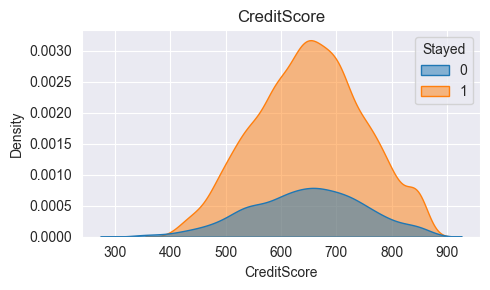

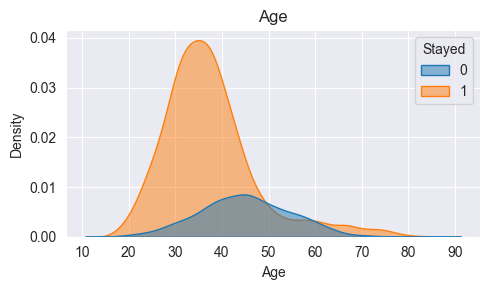

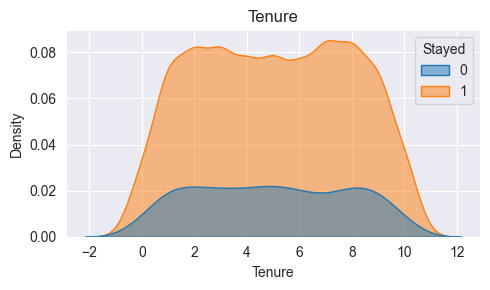

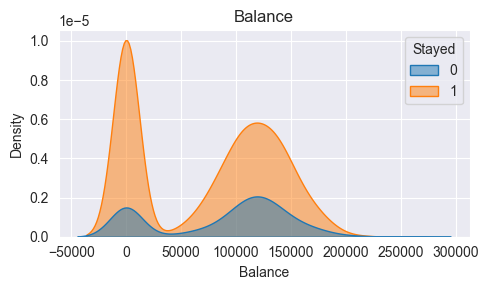

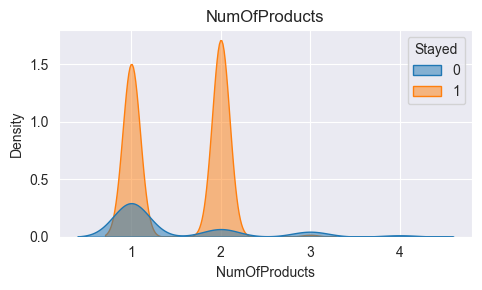

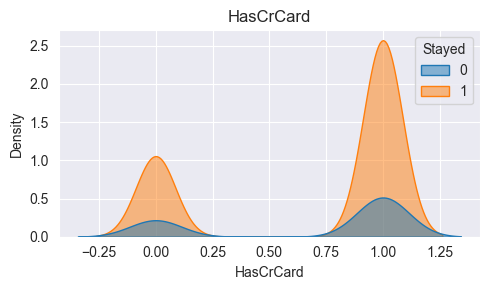

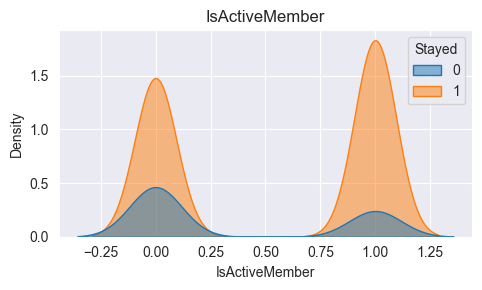

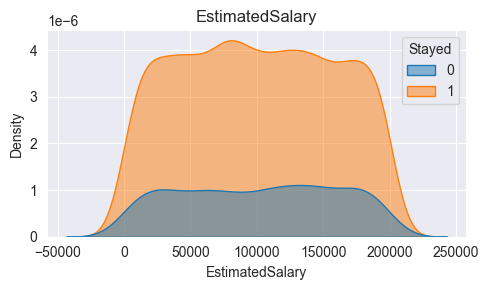

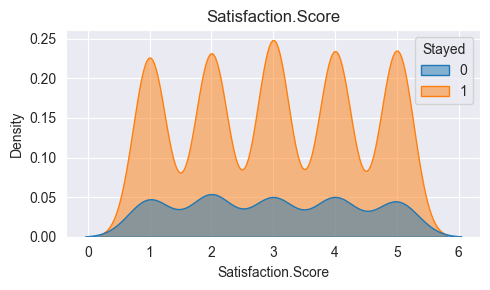

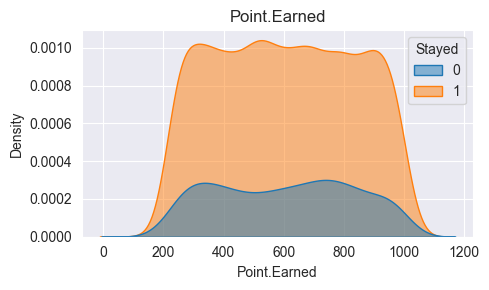

,Kolona,KS_stat,p_vrednost
1,Age,0.391956,7.850921e-112
4,NumOfProducts,0.238660,5.715901e-41
6,IsActiveMember,0.212022,2.337523e-32
3,Balance,0.135670,1.883458e-13
0,CreditScore,0.034214,2.918575e-01
7,EstimatedSalary,0.030504,4.286997e-01
9,Point.Earned,0.028106,5.337428e-01
2,Tenure,0.023256,7.629856e-01
8,Satisfaction.Score,0.022015,8.176875e-01
5,HasCrCard,0.005274,1.000000e+00


Kolone sa malom razlikom između klasa: ['CreditScore', 'EstimatedSalary', 'Point.Earned', 'Tenure', 'Satisfaction.Score', 'HasCrCard']
<class 'pandas.core.frame.DataFrame'>
Index: 4897 entries, 0 to 4897
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Geography       4897 non-null   object 
 1   Gender          4897 non-null   object 
 2   Age             4897 non-null   float64
 3   Balance         4897 non-null   float64
 4   NumOfProducts   4897 non-null   int64  
 5   IsActiveMember  4897 non-null   int64  
 6   Card.Type       4897 non-null   object 
 7   Stayed          4897 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 344.3+ KB


In [11]:
target = 'Stayed'

# Numeričke kolone
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target)

# Napravi prazan DataFrame za metrike
results = []

for col in num_cols:
    # Kreiraj KDE plot za svaku kolonu
    plt.figure(figsize=(5, 3))
    sns.kdeplot(data=df, x=col, hue=target, fill=True, alpha=0.5)
    plt.title(col)
    plt.tight_layout()
    plt.show()

    # Izračunaj KS statistiku između klasa
    group1 = df[df[target] == df[target].unique()[0]][col].dropna()
    group2 = df[df[target] == df[target].unique()[1]][col].dropna()
    stat, pval = ks_2samp(group1, group2)

    results.append({'Kolona': col, 'KS_stat': stat, 'p_vrednost': pval})

# Rezultati kao tabela
results_df = pd.DataFrame(results).sort_values(by='KS_stat', ascending=False)
display(results_df)

# Ako želiš da automatski odbaciš one sa malom razlikom (npr. KS_stat < 0.1)
low_sep = results_df[results_df['KS_stat'] < 0.1]['Kolona'].tolist()
print("Kolone sa malom razlikom između klasa:", low_sep)

df.drop(columns=low_sep, inplace=True)
df.info()

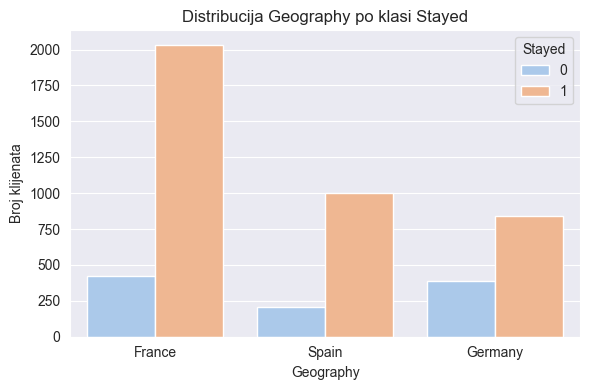

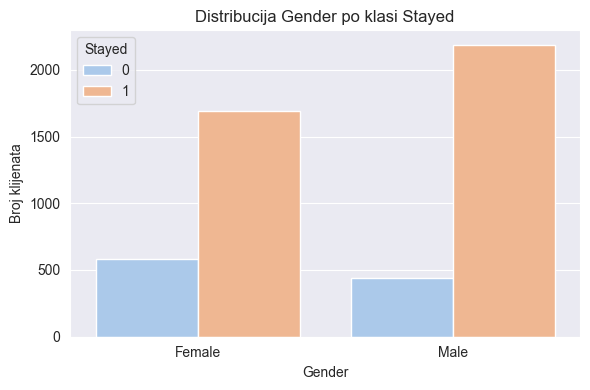

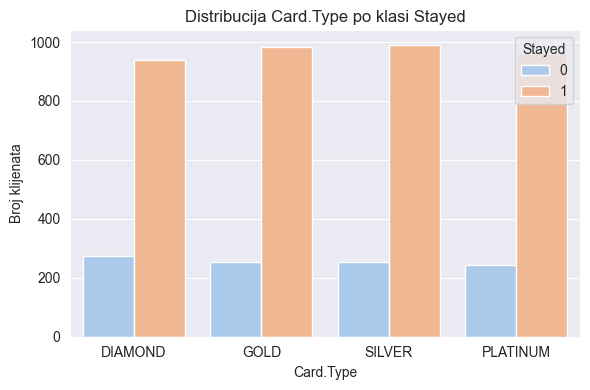

In [12]:
# Bar plotovi za Geography, Gender i Card.Type grupisani po Stayed
for col in ['Geography', 'Gender', 'Card.Type']:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='Stayed', palette='pastel')
    plt.title(f'Distribucija {col} po klasi Stayed')
    plt.xlabel(col)
    plt.ylabel('Broj klijenata')
    plt.legend(title='Stayed')
    plt.tight_layout()
    plt.show()

In [13]:
#Geography treba zadržati jer se proporcije za varijablu Stayed značajno razlikuju po zemljama (npr. klijenti iz Francuske ostaju u mnogo većem delu nego oni iz Španije i Nemačke).
#IsActiveMember pokazuje jasnu razliku u proporcijama Stayed/Not stayed i treba je zadržati, dok HasCrCard nema značajan doprinos.
df.drop(columns=['Card.Type'], inplace=True)

### Priprema podataka za uključivanje u model - Prebacivanje u numeric

In [14]:
df.select_dtypes(include=object).info()

<class 'pandas.core.frame.DataFrame'>
Index: 4897 entries, 0 to 4897
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Geography  4897 non-null   object
 1   Gender     4897 non-null   object
dtypes: object(2)
memory usage: 114.8+ KB


In [15]:
df.Geography.value_counts()

Geography
France     2456
Germany    1231
Spain      1210
Name: count, dtype: int64

In [16]:
df.Gender.value_counts()

Gender
Male      2623
Female    2274
Name: count, dtype: int64

In [17]:
#S obzirom da su varijable Geography i Gender kategoričke, koristi se One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False, drop='first')
cats = ['Geography', 'Gender']
encoded_array = ohe.fit_transform(df[cats])
encoded_cols = ohe.get_feature_names_out(cats)

df_ohe = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)
df = df.drop(columns=cats).join(df_ohe)

In [18]:
df.head(10)

,Age,Balance,NumOfProducts,IsActiveMember,Stayed,Geography_Germany,Geography_Spain,Gender_Male
0,37.0,0.00,1,1,0,0.0,0.0,0.0
1,41.0,83807.86,1,1,1,0.0,1.0,0.0
2,42.0,159660.80,3,0,0,0.0,0.0,0.0
3,39.0,0.00,2,0,1,0.0,0.0,0.0
4,43.0,125510.82,1,1,1,0.0,1.0,0.0
5,44.0,113755.78,2,0,0,0.0,1.0,1.0
6,50.0,0.00,2,1,1,0.0,0.0,1.0
7,29.0,115046.74,4,0,0,1.0,0.0,0.0
8,44.0,142051.07,2,1,1,0.0,0.0,1.0
9,27.0,134603.88,1,1,1,0.0,0.0,1.0


### Podela podataka na train i test dataset

In [19]:
X = df.drop(columns='Stayed')
y = df['Stayed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Raspodela klasa u trening i test skupu
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Stayed
1    0.791167
0    0.208833
Name: proportion, dtype: float64
Stayed
1    0.790816
0    0.209184
Name: proportion, dtype: float64


### Izračunavanje optimalne vrednosti parametra ccp_alpha

In [20]:
cv  = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
param_grid = {'ccp_alpha':np.arange(0.0,0.05,0.0025)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                    param_grid=param_grid,
                    cv=cv,
                    scoring='accuracy')
grid.fit(X_train, y_train)

best_ccp_alpha = grid.best_params_['ccp_alpha']
print("Najbolja vrednost ccp_alpha:",best_ccp_alpha)

Najbolja vrednost ccp_alpha: 0.005


### Kreiranje modela stabla odlučivanja

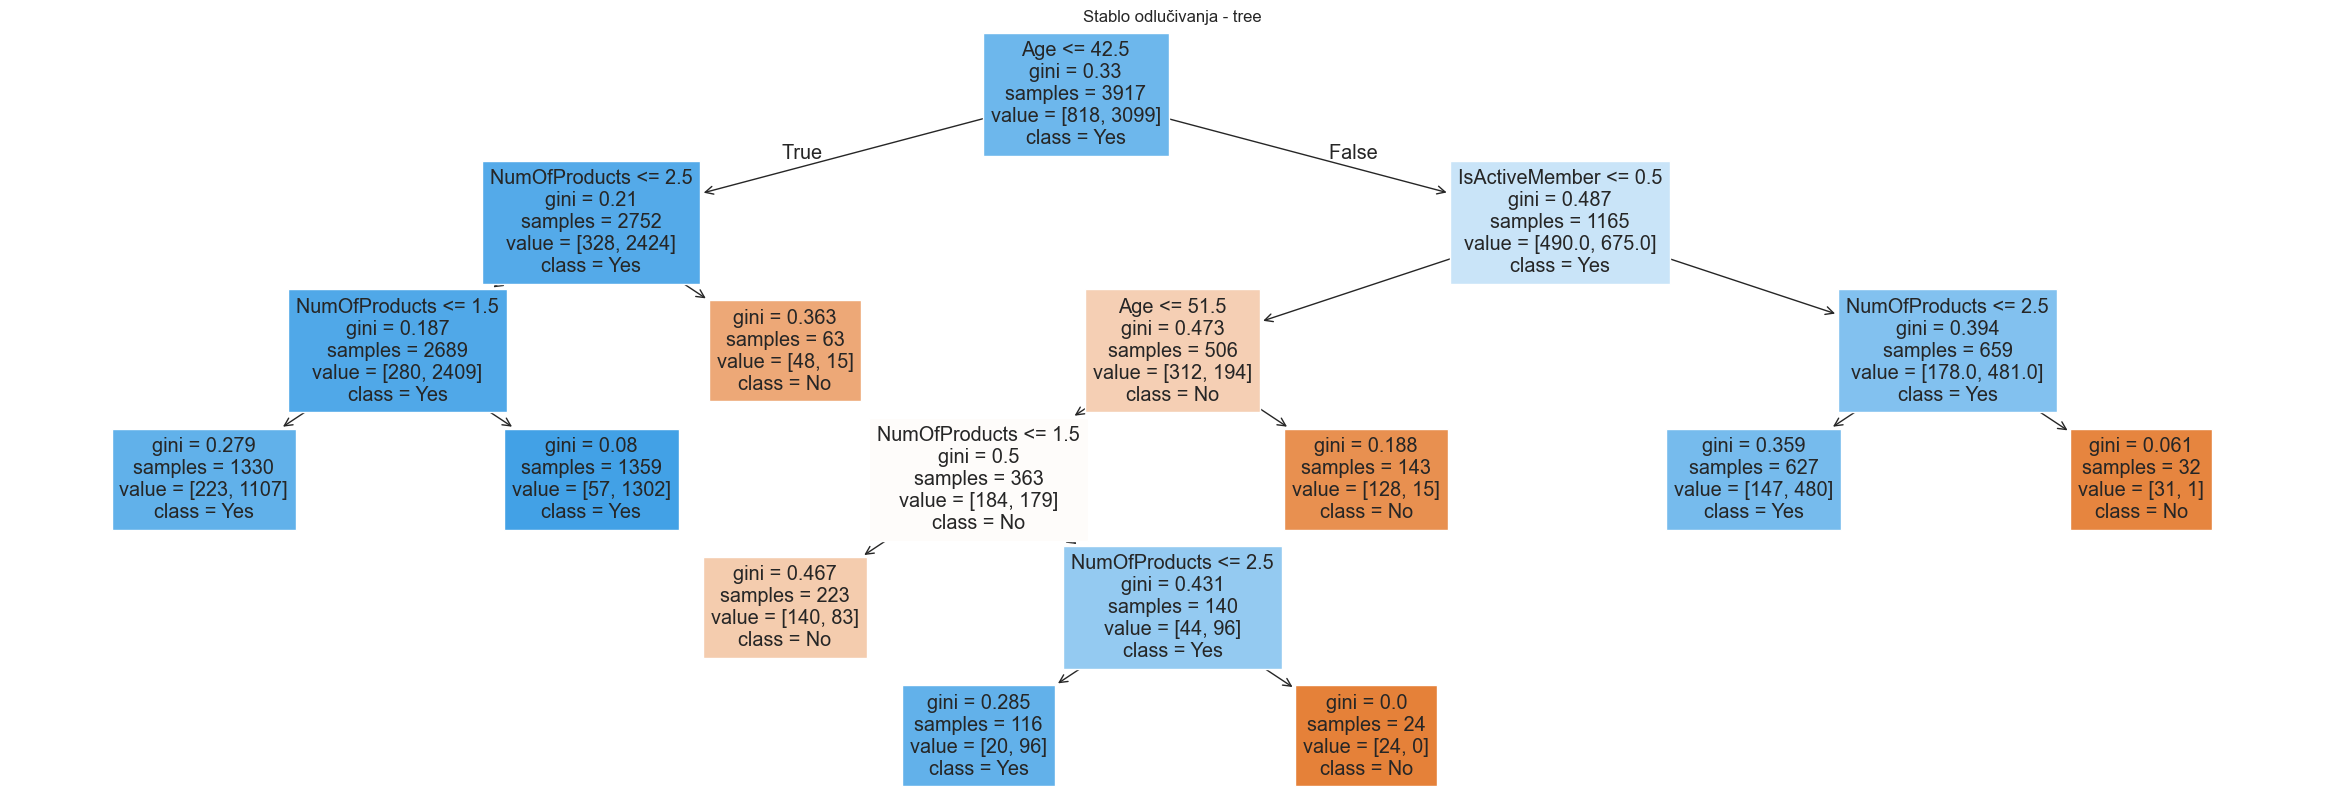

In [21]:
tree = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha,random_state=42)
tree.fit(X_train, y_train)

# Vizualizacija stabla odlučivanja
plt.figure(figsize=[30,10])
plot_tree(tree,
          feature_names=X_train.columns,
          class_names=['No','Yes'],filled=True
          )
plt.title("Stablo odlučivanja - tree")
plt.show()

In [22]:
# Kreiranje predikcije za test skup za tree
y_pred = tree.predict(X_test)

### Kreiranje matrice konfuzije

In [23]:
cm = confusion_matrix(y_test, y_pred)
print("Matrica kofuzije:")
print(cm)

Matrica kofuzije:
[[ 92 113]
 [ 30 745]]


In [24]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

accuracy = (TP + TN)/cm.sum()
precision = TP/(TP + FP)
recall = TP/(TP + FN)
F1 = 2*precision*recall/(precision + recall)

print(f"accuracy = {accuracy},\nprecision = {precision},\nrecall = {recall},\nF1 = {F1}")

accuracy = 0.8540816326530613,
precision = 0.8682983682983683,
recall = 0.9612903225806452,
F1 = 0.9124311083894673
